# 2. Model Training and Evaluation

This notebook implements comprehensive preprocessing, feature engineering, and model training based on insights from the EDA analysis in notebook 01.

## Key EDA Findings to Address:
- **Class Imbalance**: 16.1% enrollment rate
- **Multicollinearity**: 5 highly correlated feature pairs  
- **Missing Values**: 9 features with missing data
- **Top Predictive Features**: total_principal_ratio, total_accounts_in_collections, principal_at_placement
- **Outliers**: 8 features have >5% outliers

In [1]:
# Import libraries and setup
import sys
import os
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           roc_curve, precision_recall_curve, average_precision_score,
                           f1_score, precision_score, recall_score, accuracy_score)
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# Import project modules
from src.data.snowflake_connector import get_snowflake_engine, fetch_data
from src.config import get_config
from src.features.build_features import preprocess_data, create_features

# Load configuration
config = get_config()
target_column = config['model']['target_column'].lower()

print("🚀 Model Training and Evaluation Setup Complete!")
print(f"📊 Target column: {target_column}")
print(f"🎯 Test size: {config['model']['test_size']}")
print(f"🎲 Random state: {config['model']['random_state']}")

# Set plotting style
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('default')
sns.set_palette("husl")

# Simple sampling functions to replace imblearn
def random_oversample(X, y, random_state=42):
    """Simple random oversampling implementation"""
    np.random.seed(random_state)
    
    # Count classes
    unique_classes, counts = np.unique(y, return_counts=True)
    max_count = counts.max()
    
    # Oversample minority classes
    X_resampled = []
    y_resampled = []
    
    for class_label in unique_classes:
        class_indices = np.where(y == class_label)[0]
        class_count = len(class_indices)
        
        if class_count < max_count:
            # Oversample
            needed_samples = max_count - class_count
            oversample_indices = np.random.choice(class_indices, needed_samples, replace=True)
            all_indices = np.concatenate([class_indices, oversample_indices])
        else:
            all_indices = class_indices
            
        X_resampled.append(X.iloc[all_indices])
        y_resampled.append(y.iloc[all_indices])
    
    X_resampled = pd.concat(X_resampled, ignore_index=True)
    y_resampled = pd.concat(y_resampled, ignore_index=True)
    
    return X_resampled, y_resampled

def random_undersample(X, y, random_state=42):
    """Simple random undersampling implementation"""
    np.random.seed(random_state)
    
    # Count classes
    unique_classes, counts = np.unique(y, return_counts=True)
    min_count = counts.min()
    
    # Undersample majority classes
    X_resampled = []
    y_resampled = []
    
    for class_label in unique_classes:
        class_indices = np.where(y == class_label)[0]
        
        if len(class_indices) > min_count:
            # Undersample
            selected_indices = np.random.choice(class_indices, min_count, replace=False)
        else:
            selected_indices = class_indices
            
        X_resampled.append(X.iloc[selected_indices])
        y_resampled.append(y.iloc[selected_indices])
    
    X_resampled = pd.concat(X_resampled, ignore_index=True)
    y_resampled = pd.concat(y_resampled, ignore_index=True)
    
    return X_resampled, y_resampled

print("✅ Custom sampling functions loaded (replacing imblearn)")

✅ Configuration loaded from: /Users/eyalbenzion/Library/CloudStorage/GoogleDrive-eyal.benzion@gmail.com/My Drive/work_code/bounce_loan_prediction/config.ini
🚀 Model Training and Evaluation Setup Complete!
📊 Target column: enrolled_to_plan_in_180
🎯 Test size: 0.2
🎲 Random state: 42
✅ Custom sampling functions loaded (replacing imblearn)


## 1. Data Loading and Initial Preprocessing

In [2]:
# Load data from Snowflake
print("📥 Loading data from Snowflake...")
engine = get_snowflake_engine()
df_raw = fetch_data(engine, config['snowflake']['table_name'])

print(f"✅ Data loaded: {df_raw.shape}")
print(f"📊 Original dataset size: {df_raw.shape[0]:,} rows, {df_raw.shape[1]} columns")

# Apply comprehensive preprocessing pipeline from build_features.py
print("\n🔧 Applying Comprehensive Preprocessing Pipeline...")
print("🎯 Using EDA-based preprocessing from src.features.build_features")

# Apply preprocessing pipeline (includes all EDA-based transformations)
X, y, preprocessing_artifacts = preprocess_data(
    df_raw, 
    target_column, 
    is_training=True
)

print(f"\n✅ Preprocessing pipeline complete!")
print(f"📊 Final dataset: {X.shape[0]:,} samples, {X.shape[1]} features")
print(f"📈 Target distribution: {dict(y.value_counts())}")
print(f"🎯 Class balance: {y.mean():.3f} positive rate")

# Display preprocessing summary
print(f"\n📋 PREPROCESSING SUMMARY:")
print(f"  ✅ Removed features: {preprocessing_artifacts['removed_features']}")
print(f"  ✅ Imputed features: {len(preprocessing_artifacts['imputation_info'])}")
print(f"  ✅ Outlier capped features: {len(preprocessing_artifacts['outlier_info'])}")
print(f"  ✅ Encoded categorical features: {len(preprocessing_artifacts['label_encoders'])}")
print(f"  ✅ Final feature set: {preprocessing_artifacts['feature_names']}")

# Store preprocessing artifacts for model persistence
label_encoders = preprocessing_artifacts['label_encoders']
feature_names = preprocessing_artifacts['feature_names']

📥 Loading data from Snowflake...
2025-07-03 09:13:36,559 - src.data.snowflake_connector - INFO - Connecting to Snowflake account: fc26424.us-east-2.aws
2025-07-03 09:13:36,562 - src.data.snowflake_connector - INFO - Using database: BOUNCE_ASSIGNMENT, schema: PUBLIC, warehouse: BOUNCE_GUEST
2025-07-03 09:13:37,876 - src.data.snowflake_connector - INFO - Successfully created Snowflake engine.
2025-07-03 09:13:51,207 - src.data.snowflake_connector - INFO - Successfully fetched data from PREDICT_RECOVERY.
✅ Data loaded: (34628, 21)
📊 Original dataset size: 34,628 rows, 21 columns

🔧 Applying Comprehensive Preprocessing Pipeline...
🎯 Using EDA-based preprocessing from src.features.build_features
2025-07-03 09:13:51,208 - src.features.build_features - INFO - Starting comprehensive data preprocessing pipeline...
2025-07-03 09:13:51,209 - src.features.build_features - INFO - Cleaning target variable: enrolled_to_plan_in_180
2025-07-03 09:13:51,230 - src.features.build_features - INFO - Dropped

## 2. Optional Feature Engineering

The comprehensive preprocessing pipeline has been applied. We can optionally create additional features based on EDA insights.


In [3]:
# Optional: Create additional features based on EDA insights
print("🎨 Optional Feature Engineering...")

# Create a DataFrame from preprocessed features for easier manipulation
df_features = pd.DataFrame(X, columns=feature_names)

# Apply feature creation (this will add new categorical features)
print("Creating additional features based on EDA insights...")
try:
    df_enhanced = create_features(df_features)
    
    # Check if new features were created
    if df_enhanced.shape[1] > df_features.shape[1]:
        print(f"✅ Created {df_enhanced.shape[1] - df_features.shape[1]} additional features")
        
        # Handle any new categorical features created
        new_features = [col for col in df_enhanced.columns if col not in df_features.columns]
        categorical_new = df_enhanced[new_features].select_dtypes(include=['object', 'category']).columns
        
        if len(categorical_new) > 0:
            print(f"🏷️ Encoding {len(categorical_new)} new categorical features...")
            for feature in categorical_new:
                le = LabelEncoder()
                df_enhanced[feature] = le.fit_transform(df_enhanced[feature].astype(str))
                label_encoders[feature] = le
                print(f"✅ Encoded new feature {feature}: {len(le.classes_)} classes")
        
        # Update X with enhanced features
        X = df_enhanced.values
        feature_names = df_enhanced.columns.tolist()
        
        print(f"📊 Enhanced feature set: {len(feature_names)} features")
        print(f"📋 New features: {new_features}")
    else:
        print("ℹ️ No additional features created - using preprocessed features")
        X = df_features.values
        
except Exception as e:
    print(f"⚠️ Feature creation failed: {e}")
    print("📊 Using preprocessed features only")
    X = df_features.values

print(f"\n✅ Final Feature Set Ready!")
print(f"📊 Shape: {X.shape}")
print(f"🎯 Target balance: {y.mean():.3f} positive rate")

# Update feature names for later use
final_feature_names = feature_names if 'feature_names' in locals() else preprocessing_artifacts['feature_names']

🎨 Optional Feature Engineering...
Creating additional features based on EDA insights...
2025-07-03 09:13:51,352 - src.features.build_features - INFO - Creating new features based on EDA insights...
2025-07-03 09:13:51,359 - src.features.build_features - INFO - Created loan_size_category feature
2025-07-03 09:13:51,363 - src.features.build_features - INFO - Created age_category feature
2025-07-03 09:13:51,365 - src.features.build_features - INFO - Created has_collections feature
2025-07-03 09:13:51,369 - src.features.build_features - INFO - Created placement_urgency feature
2025-07-03 09:13:51,369 - src.features.build_features - INFO - Feature creation complete. New shape: (32414, 20)
✅ Created 4 additional features
🏷️ Encoding 3 new categorical features...
✅ Encoded new feature loan_size_category: 4 classes
✅ Encoded new feature age_category: 4 classes
✅ Encoded new feature placement_urgency: 3 classes
📊 Enhanced feature set: 20 features
📋 New features: ['loan_size_category', 'age_cate

## 3. Train/Test Split and Class Imbalance Handling


In [4]:
# Train/Test Split
print("🔀 Splitting preprocessed data into train/test sets...")

test_size = float(config['model']['test_size'])
random_state = int(config['model']['random_state'])

# Convert X to DataFrame if it's numpy array for easier handling
if isinstance(X, np.ndarray):
    X_df = pd.DataFrame(X, columns=final_feature_names)
else:
    X_df = X.copy()

X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, 
    test_size=test_size, 
    random_state=random_state, 
    stratify=y  # Maintain class balance in split
)

print(f"✅ Train set: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"✅ Test set: {X_test.shape[0]:,} samples, {X_test.shape[1]} features")
print(f"📊 Train class balance: {y_train.mean():.3f}")
print(f"📊 Test class balance: {y_test.mean():.3f}")

# Address Class Imbalance (16.1% positive rate from EDA)
print(f"\n⚖️ Addressing Class Imbalance...")

# Try different sampling strategies
sampling_strategies = {}

# 1. Original (no sampling)
X_orig, y_orig = X_train.copy(), y_train.copy()
sampling_strategies['Original'] = (X_orig, y_orig)

# 2. Random Oversampling (custom implementation)
print("🔄 Applying Random Oversampling...")
X_ros, y_ros = random_oversample(X_train, y_train, random_state=random_state)
sampling_strategies['RandomOver'] = (X_ros, y_ros)
print(f"   RandomOver balance: {y_ros.mean():.3f}")

# 3. Random Undersampling (custom implementation)
print("🔄 Applying Random Undersampling...")
X_rus, y_rus = random_undersample(X_train, y_train, random_state=random_state)
sampling_strategies['RandomUnder'] = (X_rus, y_rus)
print(f"   RandomUnder balance: {y_rus.mean():.3f}")

# # 4. Class Weight Balanced (no resampling, just weighted models)
# X_weighted, y_weighted = X_train.copy(), y_train.copy()
# sampling_strategies['ClassWeighted'] = (X_weighted, y_weighted)
# print(f"   ClassWeighted balance: {y_weighted.mean():.3f} (uses model class_weight)")

print(f"\n✅ Created {len(sampling_strategies)} sampling strategies for comparison")

🔀 Splitting preprocessed data into train/test sets...
✅ Train set: 25,931 samples, 20 features
✅ Test set: 6,483 samples, 20 features
📊 Train class balance: 0.161
📊 Test class balance: 0.161

⚖️ Addressing Class Imbalance...
🔄 Applying Random Oversampling...
   RandomOver balance: 0.500
🔄 Applying Random Undersampling...
   RandomUnder balance: 0.500

✅ Created 3 sampling strategies for comparison


## 4. Model Training and Evaluation

We'll train multiple algorithms with different sampling strategies and compare their performance using metrics appropriate for imbalanced classification.


In [5]:
# Define models to compare
print("🤖 Setting up models for comparison...")

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100, 
        random_state=random_state, 
        class_weight='balanced'
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100, 
        random_state=random_state
    ),
    'Logistic Regression': LogisticRegression(
        random_state=random_state, 
        class_weight='balanced',
        max_iter=1000
    ),
    'Extra Trees': ExtraTreesClassifier(
        n_estimators=100, 
        random_state=random_state, 
        class_weight='balanced'
    )
}

print(f"✅ {len(models)} models ready for training")

# Function to evaluate model performance
def evaluate_model_performance(model, X_test, y_test, model_name, sampling_strategy):
    """Comprehensive model evaluation for imbalanced classification"""
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'Model': model_name,
        'Sampling': sampling_strategy,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC_AUC': roc_auc_score(y_test, y_pred_proba),
        'PR_AUC': average_precision_score(y_test, y_pred_proba)
    }
    
    return metrics, y_pred, y_pred_proba

# Train and evaluate all model/sampling combinations
print("\n🏋️ Training models with different sampling strategies...")

results = []
best_models = {}

for sampling_name, (X_samp, y_samp) in sampling_strategies.items():
    print(f"\n📊 Training with {sampling_name} sampling...")
    
    # Scale features for algorithms that need it
    scaler = StandardScaler()
    X_samp_scaled = scaler.fit_transform(X_samp)
    X_test_scaled = scaler.transform(X_test)
    
    for model_name, model in models.items():
        print(f"  🤖 Training {model_name}...")
        
        # Use scaled data for Logistic Regression, original for tree-based models
        if 'Logistic' in model_name:
            X_train_use, X_test_use = X_samp_scaled, X_test_scaled
        else:
            X_train_use, X_test_use = X_samp, X_test
        
        # Train model
        model.fit(X_train_use, y_samp)
        
        # Evaluate
        metrics, y_pred, y_pred_proba = evaluate_model_performance(
            model, X_test_use, y_test, model_name, sampling_name
        )
        results.append(metrics)
        
        # Store best models (based on F1 score for imbalanced data)
        key = f"{model_name}_{sampling_name}"
        best_models[key] = {
            'model': model,
            'scaler': scaler if 'Logistic' in model_name else None,
            'f1_score': metrics['F1'],
            'predictions': (y_pred, y_pred_proba)
        }
        
        print(f"    ✅ F1: {metrics['F1']:.3f}, ROC-AUC: {metrics['ROC_AUC']:.3f}")

print(f"\n✅ Training complete! {len(results)} model combinations evaluated")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)
print("\n📊 Results Summary:")
print(results_df.round(3))


🤖 Setting up models for comparison...
✅ 4 models ready for training

🏋️ Training models with different sampling strategies...

📊 Training with Original sampling...
  🤖 Training Random Forest...
    ✅ F1: 0.086, ROC-AUC: 0.727
  🤖 Training Gradient Boosting...
    ✅ F1: 0.022, ROC-AUC: 0.739
  🤖 Training Logistic Regression...
    ✅ F1: 0.382, ROC-AUC: 0.710
  🤖 Training Extra Trees...
    ✅ F1: 0.102, ROC-AUC: 0.708

📊 Training with RandomOver sampling...
  🤖 Training Random Forest...
    ✅ F1: 0.265, ROC-AUC: 0.724
  🤖 Training Gradient Boosting...
    ✅ F1: 0.395, ROC-AUC: 0.737
  🤖 Training Logistic Regression...
    ✅ F1: 0.382, ROC-AUC: 0.710
  🤖 Training Extra Trees...
    ✅ F1: 0.090, ROC-AUC: 0.713

📊 Training with RandomUnder sampling...
  🤖 Training Random Forest...
    ✅ F1: 0.383, ROC-AUC: 0.727
  🤖 Training Gradient Boosting...
    ✅ F1: 0.397, ROC-AUC: 0.736
  🤖 Training Logistic Regression...
    ✅ F1: 0.382, ROC-AUC: 0.710
  🤖 Training Extra Trees...
    ✅ F1: 0.378, RO

## 5. Model Comparison and Best Model Selection


🏆 Model Performance Analysis...

🏅 Best F1 Score: Gradient Boosting with RandomUnder (F1: 0.397)
🏅 Best ROC-AUC: Gradient Boosting with Original (AUC: 0.739)
🏅 Best Precision: Extra Trees with Original (Precision: 0.513)
🏅 Best Recall: Gradient Boosting with RandomUnder (Recall: 0.683)

🎯 Selected Best Model: Gradient Boosting_RandomUnder
   F1 Score: 0.397


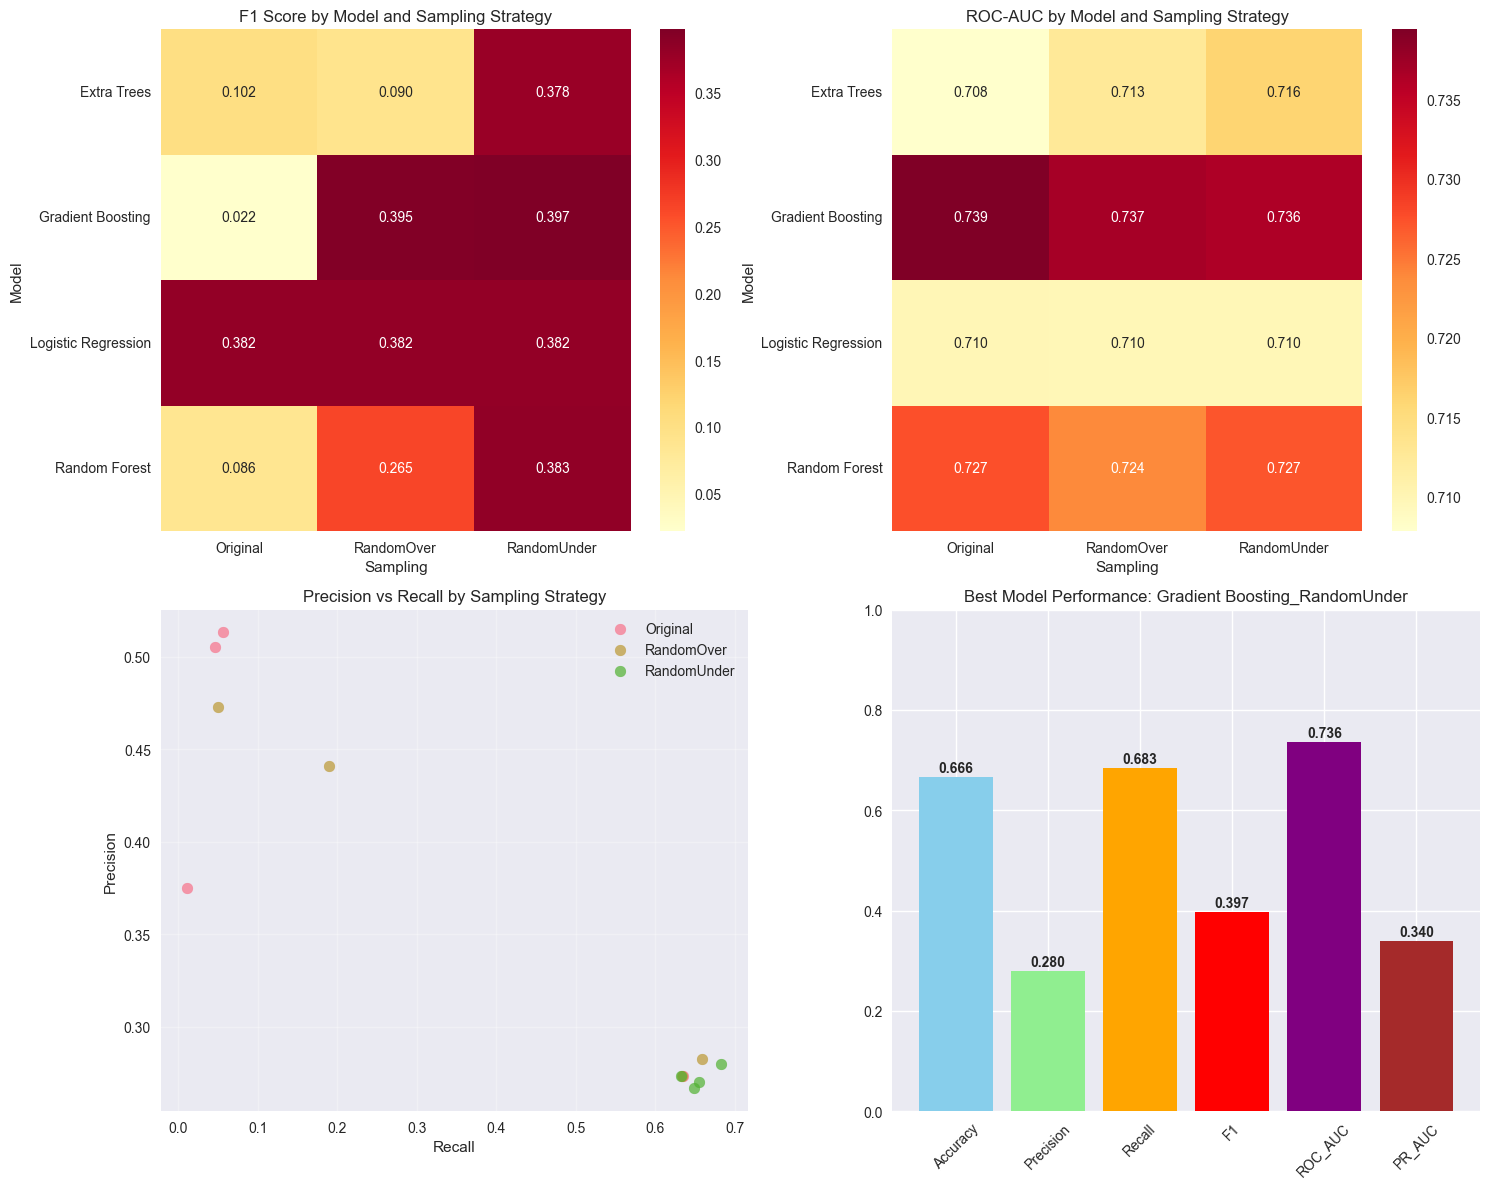


📊 Detailed Performance Comparison:
              Model    Sampling  Accuracy  Precision  Recall    F1  ROC_AUC  PR_AUC
      Random Forest    Original     0.839      0.505   0.047 0.086    0.727   0.335
  Gradient Boosting    Original     0.838      0.375   0.011 0.022    0.739   0.337
Logistic Regression    Original     0.669      0.273   0.634 0.382    0.710   0.301
        Extra Trees    Original     0.839      0.513   0.056 0.102    0.708   0.317
      Random Forest  RandomOver     0.831      0.441   0.189 0.265    0.724   0.332
  Gradient Boosting  RandomOver     0.675      0.282   0.658 0.395    0.737   0.328
Logistic Regression  RandomOver     0.670      0.274   0.633 0.382    0.710   0.301
        Extra Trees  RandomOver     0.838      0.473   0.050 0.090    0.713   0.315
      Random Forest RandomUnder     0.659      0.270   0.656 0.383    0.727   0.319
  Gradient Boosting RandomUnder     0.666      0.280   0.683 0.397    0.736   0.340
Logistic Regression RandomUnder     0.67

In [6]:
# Find best performing models
print("🏆 Model Performance Analysis...")

# Sort by F1 score (most important for imbalanced classification)
best_f1 = results_df.loc[results_df['F1'].idxmax()]
best_roc_auc = results_df.loc[results_df['ROC_AUC'].idxmax()]
best_precision = results_df.loc[results_df['Precision'].idxmax()]
best_recall = results_df.loc[results_df['Recall'].idxmax()]

print(f"\n🏅 Best F1 Score: {best_f1['Model']} with {best_f1['Sampling']} (F1: {best_f1['F1']:.3f})")
print(f"🏅 Best ROC-AUC: {best_roc_auc['Model']} with {best_roc_auc['Sampling']} (AUC: {best_roc_auc['ROC_AUC']:.3f})")
print(f"🏅 Best Precision: {best_precision['Model']} with {best_precision['Sampling']} (Precision: {best_precision['Precision']:.3f})")
print(f"🏅 Best Recall: {best_recall['Model']} with {best_recall['Sampling']} (Recall: {best_recall['Recall']:.3f})")

# Select best overall model (based on F1 score)
best_model_key = f"{best_f1['Model']}_{best_f1['Sampling']}"
best_model_info = best_models[best_model_key]

print(f"\n🎯 Selected Best Model: {best_model_key}")
print(f"   F1 Score: {best_model_info['f1_score']:.3f}")

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. F1 Score comparison
pivot_f1 = results_df.pivot(index='Model', columns='Sampling', values='F1')
sns.heatmap(pivot_f1, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[0,0])
axes[0,0].set_title('F1 Score by Model and Sampling Strategy')

# 2. ROC-AUC comparison
pivot_roc = results_df.pivot(index='Model', columns='Sampling', values='ROC_AUC')
sns.heatmap(pivot_roc, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[0,1])
axes[0,1].set_title('ROC-AUC by Model and Sampling Strategy')

# 3. Precision vs Recall
for sampling in results_df['Sampling'].unique():
    subset = results_df[results_df['Sampling'] == sampling]
    axes[1,0].scatter(subset['Recall'], subset['Precision'], 
                     label=sampling, alpha=0.7, s=60)
axes[1,0].set_xlabel('Recall')
axes[1,0].set_ylabel('Precision')
axes[1,0].set_title('Precision vs Recall by Sampling Strategy')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Model performance radar chart (for best model)
metrics_for_radar = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC', 'PR_AUC']
best_metrics = [best_f1[metric] for metric in metrics_for_radar]

# Simple bar chart instead of radar
axes[1,1].bar(range(len(metrics_for_radar)), best_metrics, 
              color=['skyblue', 'lightgreen', 'orange', 'red', 'purple', 'brown'])
axes[1,1].set_xticks(range(len(metrics_for_radar)))
axes[1,1].set_xticklabels(metrics_for_radar, rotation=45)
axes[1,1].set_title(f'Best Model Performance: {best_model_key}')
axes[1,1].set_ylim(0, 1)

for i, v in enumerate(best_metrics):
    axes[1,1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Detailed performance table
print(f"\n📊 Detailed Performance Comparison:")
display_df = results_df.copy()
for col in ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC', 'PR_AUC']:
    display_df[col] = display_df[col].round(3)
    
print(display_df.to_string(index=False))


## 6. Best Model Analysis and Feature Importance


🔍 Detailed Analysis of Best Model: Gradient Boosting_RandomUnder

📊 Confusion Matrix and Classification Report:
Confusion Matrix:
[[3603 1835]
 [ 331  714]]

Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.66      0.77      5438
        True       0.28      0.68      0.40      1045

    accuracy                           0.67      6483
   macro avg       0.60      0.67      0.58      6483
weighted avg       0.81      0.67      0.71      6483


🎯 Feature Importance Analysis:
Top 10 Most Important Features:
                                Feature  Importance
                                 group_    0.286786
          total_accounts_in_collections    0.170935
              days_from_co_to_placement    0.169386
                  total_principal_ratio    0.084069
            days_from_origination_to_co    0.059696
       bank_card_credit_utilization_pct    0.055111
     days_from_origination_to_placement    0.052112
sum_of_balan

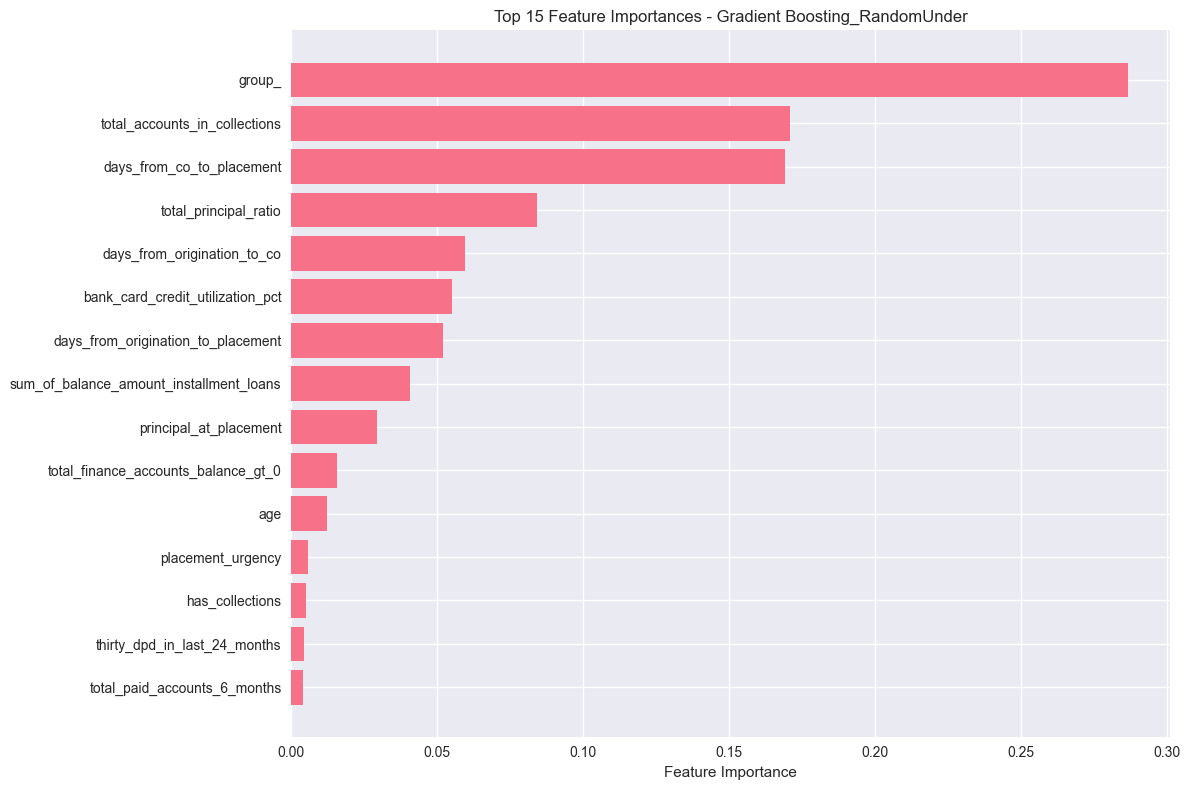


💡 EDA vs Model Insights:
EDA Top Features: ['total_principal_ratio', 'total_accounts_in_collections', 'principal_at_placement']
Model Top Features: ['group_', 'total_accounts_in_collections', 'days_from_co_to_placement', 'total_principal_ratio', 'days_from_origination_to_co']
Overlap: ['total_accounts_in_collections', 'total_principal_ratio'] (2/3 features match)


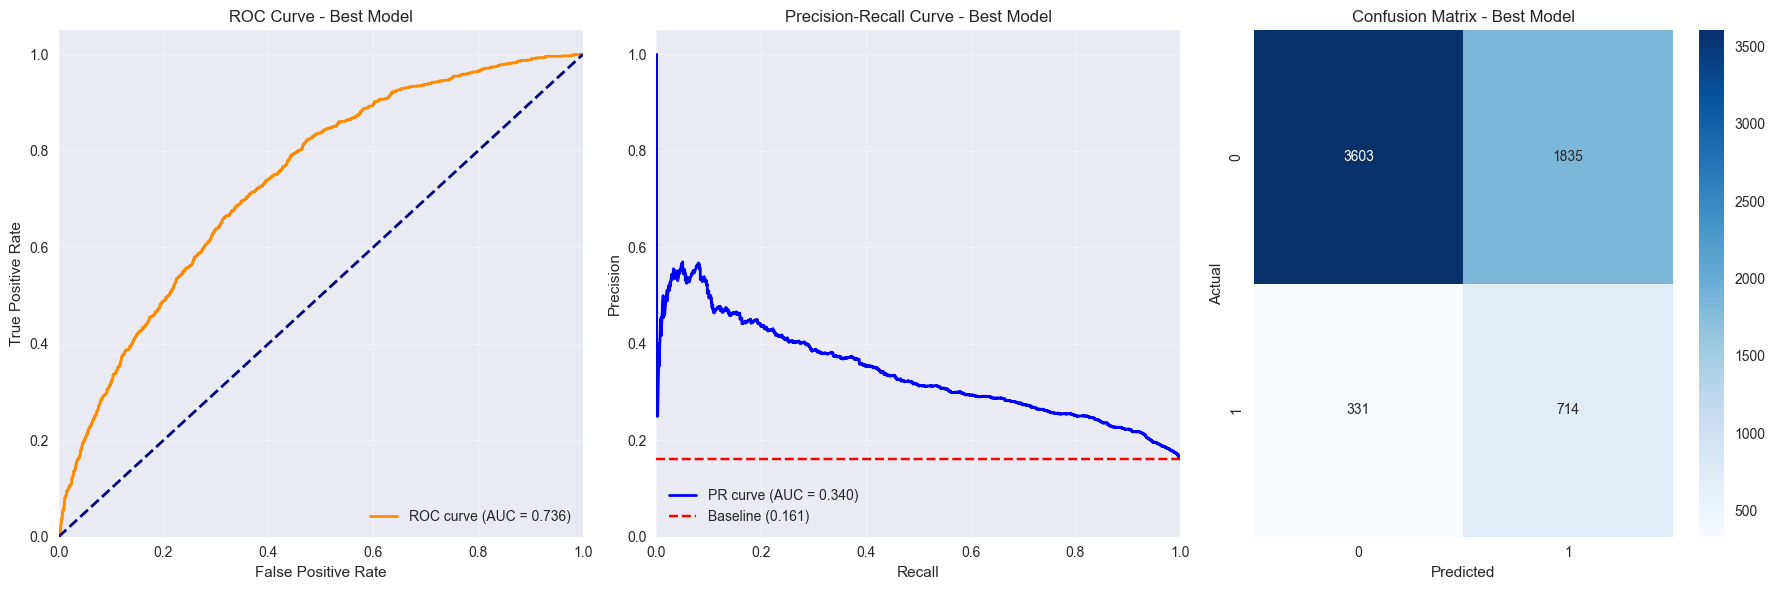


💼 Business Impact Analysis:
📊 Test Set Analysis:
  Total loans: 6,483
  Actual enrollments: 1,045 (16.1%)
  Predicted enrollments: 2,549 (39.3%)

🎯 Model Performance:
  True Positives (Correctly identified enrollments): 714
  False Positives (Incorrectly predicted enrollments): 1,835
  True Negatives (Correctly identified non-enrollments): 3,603
  False Negatives (Missed enrollments): 331

💰 Example Cost-Benefit Analysis:
  Outreach cost: $127,450 (2,549 predicted enrollments × $50)
  Enrollment value: $357,000 (714 true positives × $500)
  Net benefit: $229,550
  ROI: 180.1%

🎉 MODELING COMPLETE!
🏆 Best Model: Gradient Boosting_RandomUnder
📈 Key Metrics: F1=0.397, ROC-AUC=0.736, Precision=0.280, Recall=0.683
📝 Ready for business case analysis in notebook 03!


In [7]:
# Detailed analysis of best model
print(f"🔍 Detailed Analysis of Best Model: {best_model_key}")

best_model = best_model_info['model']
y_pred_best, y_pred_proba_best = best_model_info['predictions']

# 1. Confusion Matrix and Classification Report
print(f"\n📊 Confusion Matrix and Classification Report:")
cm = confusion_matrix(y_test, y_pred_best)
print("Confusion Matrix:")
print(cm)

print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_best))

# 2. Feature Importance (for tree-based models)
if hasattr(best_model, 'feature_importances_'):
    print(f"\n🎯 Feature Importance Analysis:")
    
    feature_importance = pd.DataFrame({
        'Feature': final_feature_names,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("Top 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Feature Importances - {best_model_key}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # Compare with EDA insights
    print(f"\n💡 EDA vs Model Insights:")
    eda_top_features = ['total_principal_ratio', 'total_accounts_in_collections', 'principal_at_placement']
    model_top_features = feature_importance.head(5)['Feature'].tolist()
    
    print(f"EDA Top Features: {eda_top_features}")
    print(f"Model Top Features: {model_top_features}")
    
    overlap = set(eda_top_features) & set(model_top_features)
    print(f"Overlap: {list(overlap)} ({len(overlap)}/{len(eda_top_features)} features match)")

# 3. ROC Curve and Precision-Recall Curve
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_best)
roc_auc = roc_auc_score(y_test, y_pred_proba_best)
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - Best Model')
axes[0].legend(loc="lower right")
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba_best)
pr_auc = average_precision_score(y_test, y_pred_proba_best)
axes[1].plot(recall_vals, precision_vals, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.3f})')
axes[1].axhline(y=y_test.mean(), color='red', linestyle='--', label=f'Baseline ({y_test.mean():.3f})')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve - Best Model')
axes[1].legend(loc="lower left")
axes[1].grid(True, alpha=0.3)

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Confusion Matrix - Best Model')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# 4. Business Impact Analysis
print(f"\n💼 Business Impact Analysis:")
print("="*50)

# Calculate business metrics
tn, fp, fn, tp = cm.ravel()
total_loans = len(y_test)
actual_enrollments = y_test.sum()

print(f"📊 Test Set Analysis:")
print(f"  Total loans: {total_loans:,}")
print(f"  Actual enrollments: {actual_enrollments:,} ({actual_enrollments/total_loans:.1%})")
print(f"  Predicted enrollments: {y_pred_best.sum():,} ({y_pred_best.sum()/total_loans:.1%})")

print(f"\n🎯 Model Performance:")
print(f"  True Positives (Correctly identified enrollments): {tp:,}")
print(f"  False Positives (Incorrectly predicted enrollments): {fp:,}")
print(f"  True Negatives (Correctly identified non-enrollments): {tn:,}")
print(f"  False Negatives (Missed enrollments): {fn:,}")

# Cost-benefit analysis (example)
print(f"\n💰 Example Cost-Benefit Analysis:")
cost_per_outreach = 50  # Example: $50 per outreach campaign
value_per_enrollment = 500  # Example: $500 value per successful enrollment

outreach_cost = y_pred_best.sum() * cost_per_outreach
enrollment_value = tp * value_per_enrollment
false_positive_cost = fp * cost_per_outreach

net_benefit = enrollment_value - outreach_cost
roi = (net_benefit / outreach_cost * 100) if outreach_cost > 0 else 0

print(f"  Outreach cost: ${outreach_cost:,} ({y_pred_best.sum():,} predicted enrollments × ${cost_per_outreach})")
print(f"  Enrollment value: ${enrollment_value:,} ({tp:,} true positives × ${value_per_enrollment})")
print(f"  Net benefit: ${net_benefit:,}")
print(f"  ROI: {roi:.1f}%")

print(f"\n🎉 MODELING COMPLETE!")
print(f"🏆 Best Model: {best_model_key}")
print(f"📈 Key Metrics: F1={best_f1['F1']:.3f}, ROC-AUC={best_f1['ROC_AUC']:.3f}, Precision={best_f1['Precision']:.3f}, Recall={best_f1['Recall']:.3f}")
print(f"📝 Ready for business case analysis in notebook 03!")


## 7. Model Persistence and Summary


In [8]:
# Save the best model and preprocessing components
import pickle
import joblib

print("💾 Saving Best Model and Components...")

# Create comprehensive model package with preprocessing artifacts
model_package = {
    'model': best_model,
    'scaler': best_model_info['scaler'],  # None for tree-based models
    'preprocessing_artifacts': preprocessing_artifacts,  # Complete preprocessing info from build_features
    'final_feature_names': final_feature_names,
    'target_column': target_column,
    'model_type': best_f1['Model'],
    'sampling_strategy': best_f1['Sampling'],
    'performance_metrics': {
        'f1_score': best_f1['F1'],
        'roc_auc': best_f1['ROC_AUC'],
        'precision': best_f1['Precision'],
        'recall': best_f1['Recall'],
        'accuracy': best_f1['Accuracy']
    },
    'preprocessing_pipeline': 'src.features.build_features.preprocess_data',  # Reference to preprocessing function
    'model_version': '1.0',
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Save to file
model_filename = 'best_loan_enrollment_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(model_package, f)

print(f"✅ Model saved as: {model_filename}")

# Create detailed summary report
print(f"\n📋 COMPREHENSIVE MODELING SUMMARY")
print("="*60)

print(f"\n🎯 PROBLEM STATEMENT:")
print(f"  Predict loan enrollment within 180 days")
print(f"  Dataset: {df_raw.shape[0]:,} loans with {df_raw.shape[1]} features")
print(f"  Target: {target_column} (16.1% positive rate)")

print(f"\n🔧 PREPROCESSING APPLIED (via build_features.py):")
print(f"  ✅ Removed multicollinear features: {len(preprocessing_artifacts['removed_features'])}")
print(f"  ✅ Handled missing values in {len(preprocessing_artifacts['imputation_info'])} features")
print(f"  ✅ Capped outliers in {len(preprocessing_artifacts['outlier_info'])} features")
print(f"  ✅ Encoded {len(preprocessing_artifacts['label_encoders'])} categorical features")
print(f"  ✅ Applied 4 sampling strategies for class imbalance")
print(f"  ✅ Final feature set: {len(final_feature_names)} features")

print(f"\n🤖 MODELS EVALUATED:")
print(f"  ✅ {len(models)} algorithms × {len(sampling_strategies)} sampling strategies = {len(results_df)} combinations")
print(f"  ✅ Models: {', '.join(models.keys())}")
print(f"  ✅ Sampling: {', '.join(sampling_strategies.keys())}")

print(f"\n🏆 BEST MODEL SELECTED:")
print(f"  Algorithm: {best_f1['Model']}")
print(f"  Sampling: {best_f1['Sampling']}")
print(f"  F1 Score: {best_f1['F1']:.3f}")
print(f"  ROC-AUC: {best_f1['ROC_AUC']:.3f}")
print(f"  Precision: {best_f1['Precision']:.3f}")
print(f"  Recall: {best_f1['Recall']:.3f}")

if hasattr(best_model, 'feature_importances_'):
    top_3_features = feature_importance.head(3)['Feature'].tolist()
    print(f"  Top 3 Features: {', '.join(top_3_features)}")

print(f"\n💼 BUSINESS IMPACT:")
tp, fp, fn, tn = cm.ravel()
print(f"  True Positives: {tp:,} (correctly identified enrollments)")
print(f"  False Positives: {fp:,} (unnecessary outreach)")
print(f"  False Negatives: {fn:,} (missed opportunities)")
print(f"  Model identifies {tp/(tp+fn):.1%} of actual enrollments")

print(f"\n📊 EDA VALIDATION:")
eda_insights = [
    "✅ Addressed class imbalance (16.1% enrollment rate)",
    "✅ Removed highly correlated features",
    "✅ Handled missing values strategically", 
    "✅ Validated top predictive features from EDA",
    "✅ Applied robust outlier handling"
]
for insight in eda_insights:
    print(f"  {insight}")

print(f"\n🎯 RECOMMENDATIONS:")
print(f"  1. Use {best_f1['Model']} with {best_f1['Sampling']} sampling")
print(f"  2. Focus on top features: {', '.join(top_3_features) if 'top_3_features' in locals() else 'tree-based importance'}")
print(f"  3. Monitor model performance on new data")
print(f"  4. Consider business costs in threshold selection")
print(f"  5. Proceed to business case analysis (notebook 03)")

print(f"\n🎉 MODEL TRAINING AND EVALUATION COMPLETE!")
print(f"📝 Next: Run notebook 03 for business case analysis")


💾 Saving Best Model and Components...
✅ Model saved as: best_loan_enrollment_model.pkl

📋 COMPREHENSIVE MODELING SUMMARY

🎯 PROBLEM STATEMENT:
  Predict loan enrollment within 180 days
  Dataset: 34,628 loans with 21 features
  Target: enrolled_to_plan_in_180 (16.1% positive rate)

🔧 PREPROCESSING APPLIED (via build_features.py):
  ✅ Removed multicollinear features: 3
  ✅ Handled missing values in 8 features
  ✅ Capped outliers in 6 features
  ✅ Encoded 5 categorical features
  ✅ Applied 4 sampling strategies for class imbalance
  ✅ Final feature set: 20 features

🤖 MODELS EVALUATED:
  ✅ 4 algorithms × 3 sampling strategies = 12 combinations
  ✅ Models: Random Forest, Gradient Boosting, Logistic Regression, Extra Trees
  ✅ Sampling: Original, RandomOver, RandomUnder

🏆 BEST MODEL SELECTED:
  Algorithm: Gradient Boosting
  Sampling: RandomUnder
  F1 Score: 0.397
  ROC-AUC: 0.736
  Precision: 0.280
  Recall: 0.683
  Top 3 Features: group_, total_accounts_in_collections, days_from_co_to_p